# Generate master data sets for further analysis. 

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
%matplotlib inline

In [4]:
#pip install statsmodels

In [5]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Quality Check

## Demographics

In [8]:
demographics = pd.read_csv('data_exp_6138-v39_questionnaire-zk38.csv', sep = ",")
#demographics.head(15)
# we asked them 7 questions in total

In [9]:
demographics = demographics[demographics['Question Key'] != 'BEGIN QUESTIONNAIRE']
demographics = demographics[demographics['Question Key'] != 'END QUESTIONNAIRE']
demographics['id'] = demographics['Participant Private ID']
demographics['question'] = demographics['Question Key']
demographics['response'] = demographics['Response']
demographics = demographics[['id', 'question', 'response']]

In [10]:
d = pd.pivot_table(demographics, index = 'id', columns = 'question', values = 'response', aggfunc='first')
d = d.reset_index()
d.columns= ['id','age', 'confirmation_1', 'confirmation_2', 'gender', 'gender_numeric','handedness', 'handedness_numeric', 'degree', 'degree_numeric']


In [11]:
d['age'].astype(float).mean()

37.76

In [12]:
d['age'].astype(float).std()

11.00148750273013

In [13]:
d.groupby('gender').nunique()

id  age  confirmation_1  confirmation_2  gender  gender_numeric  \
gender                                                                    
Female  48   25               1               1       1               1   
Male    52   29               1               1       1               1   

        handedness  handedness_numeric  degree  degree_numeric  
gender                                                          
Female           2                   2       4               4  
Male             3                   3       3               3

In [14]:
d.to_csv('demographics_100.csv', sep = ',', encoding='utf-8')

## Sound Check

In [15]:
# do a quick check for sound
sound = pd.read_csv('data_exp_6138-v39_task-jgum.csv', sep = ",")
sound = sound.replace('null', np.nan)
sound = sound.replace('nan', np.nan)

In [16]:
sound = sound[np.isfinite(sound['button pressed'])]

In [17]:
correct = [1, 0, 0]* 100

In [18]:
s = (sound['button pressed'] == correct).reset_index(name = 'check')
sound = sound.reset_index()
sound = pd.merge(s[['index', 'check']], sound, on = 'index')
sound_final= sound[['Participant Private ID','button pressed','check']]

In [19]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)
#sound_final.head(300)

## rod fixing count

In [269]:
#import csv
#2jau and 5e3j are low-high and high-low
df1 = pd.read_csv('data_exp_6138-v39_task-2jau.csv', sep = ",") # high to low
df2 = pd.read_csv('data_exp_6138-v39_task-5e3j.csv', sep = ",") # low to high

In [270]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#replace all null and nan to the np.nan
df1 = df1.replace('null', np.nan)
df1 = df1.replace('nan', np.nan)
df2 = df2.replace('null', np.nan)
df2 = df2.replace('nan', np.nan)

#turn object into floats and round them and rename them
df1['end_time'] = round(df1['end_time'].astype(float))
df1['start_time'] = round(df1['start_time'].astype(float))
df1['builtin_rt'] = df1['builtin rt'].astype(float) #dont round up builtin reaction time
df1['quality_check'] = df1['rod fixing checked'].astype(float)
df1['id'] = df1['Participant Private ID']
df1['function_id'] = df1['function id']
df1['round_instance'] = df1['round instance']
df1['trial_index'] = df1['index']
df1['key_pressed'] = df1['key pressed']

df2['end_time'] = round(df2['end_time'].astype(float))
df2['start_time'] = round(df2['start_time'].astype(float))
df2['builtin_rt'] = df2['builtin_rt'].astype(float) #dont round up builtin reaction time
df2['quality_check'] = df2['rod fixing checked'].astype(float)
df2['id'] = df2['Participant Private ID']
df2['round_instance'] = df2['round_instance']
df2['function_id'] = df2['function id']
df2['trial_index'] = df2['index']
df2['key_pressed'] = df2['key pressed']

In [271]:
#select columns from df1 and df2
data1 = df1[['trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed']]
data2 = df2[['trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed']]

In [272]:
data1['order'] = ['high-low']*len(data1)
data2['order'] = ['low-high']*len(data2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [273]:
data = pd.concat([data1, data2])
data.index.nunique()
index_manual = list(range(0, len(data)))
data['index'] = index_manual
data = data.set_index('index')
data = data[data.function_id != 'caller']
data = data[pd.notnull(data['function_id'])]



In [274]:
data_useful = data[(data.function_id == "rod_fixing")|(data.function_id == "fishing_l")|(data.function_id == "fishing_h")]
data_useful = data_useful.sort_values(by = ['id', 'start_time'])


In [275]:
data_useful['trial_label'] = data_useful[['trial_index', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [276]:
d = data_useful.groupby(['id', 'round_instance'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')


In [277]:
d.latency.isna().sum()

3362

In [278]:
data_useful['latency'] = d['latency']
data_useful= data_useful.sort_index().sort_values(['id', 'start_time'])
#data_useful.head(400)

### Ritiwk's codes

In [23]:
#da = data_useful

In [94]:
#for r_instance in da['round_instance'].unique():
#    da.loc[da['round_instance'] == r_instance,'latency'] = da[da['round_instance']==r_instance].groupby('id')['start_time'].diff().shift(-1)
 

In [95]:
#da['latency'].head(400)

how are you calcualting the last latency? 

# Analysis

### Discard the first spike

In [279]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

make a copy of the original data file

In [280]:
data_original = data_useful

In [210]:
mask = data_useful.groupby(['id', 'price_displayed', 'trial_index'])['trial_index'].transform(mask_first).astype(bool)
data_useful = data_useful.loc[mask]
# now we got rid of the first spike of fishing and rod fixing

## Fishing Data

In [211]:
data_fish = data_useful[(data_useful.function_id == "fishing_l")|(data_useful.function_id == "fishing_h")]

In [269]:
data_fish.to_csv('fish_100.csv', sep = ',', encoding='utf-8')

## Rod Fixing Data

In [281]:
data_rod = data_original[(data_original.function_id == "rod_fixing")]

In [282]:
mask = data_rod.groupby(['id', 'trial_label'])['trial_label'].transform(mask_first).astype(bool)
data_rod = data_rod.loc[mask]


In [283]:
len(data_rod)

7734

In [284]:
data_rod.to_csv('rod_100_no_first_spike.csv', sep = ',', encoding='utf-8')

# Questionnaires

In [218]:
def extract_choice(ser):
    choice = []
    for s in ser:
        c = 0
        while c < len(s):
            r = json.loads(s[c])
            for key in r.keys():
                choice.append(r[key])
            c = c + 1
    return choice

## AMI

In [219]:
# import AMI
AMI = pd.read_csv('data_exp_6138-v39_task-j8g3.csv', sep = ",")
#AMI

In [220]:
AMI_group = AMI.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
# response = AMI_group['choice made'][0]
choice = extract_choice(AMI_group['choice made'])
AMI_group = AMI_group.loc[AMI_group.index.repeat(19)] #repeat no of questions times

In [221]:
AMI_group['choice'] = choice
AMI_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]*100

In [222]:
AMI_group.choice[AMI_group.choice == "Completely UNTRUE"] = 4
AMI_group.choice[AMI_group.choice == "Mostly untrue"] = 3
AMI_group.choice[AMI_group.choice == "Neither true nor untrue"] = 2
AMI_group.choice[AMI_group.choice == "Quite true"] = 1
AMI_group.choice[AMI_group.choice == "Completely TRUE"] = 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [223]:
# by taking the mean rating of the items within the subscale.
# bAMI = questions [5 9 10 11 12 16]
# sAMI = questions [2 3 4  8  15 18]
# eAMI = questions [1 6 7  14 17 19]
# trick_question = 13
# tAMI = sum
bAMI = AMI_group[(AMI_group.question_number == 5)|(AMI_group.question_number == 9)|(AMI_group.question_number == 10)|(AMI_group.question_number == 11)|(AMI_group.question_number == 12)|(AMI_group.question_number == 16)]
sAMI = AMI_group[(AMI_group.question_number == 2)|(AMI_group.question_number == 3)|(AMI_group.question_number == 4)|(AMI_group.question_number == 8)|(AMI_group.question_number == 15)|(AMI_group.question_number == 18)]
eAMI = AMI_group[(AMI_group.question_number == 1)|(AMI_group.question_number == 6)|(AMI_group.question_number == 7)|(AMI_group.question_number == 14)|(AMI_group.question_number == 17)|(AMI_group.question_number == 19)]
trick_AMI = AMI_group[(AMI_group.question_number == 13)]
bAMI = bAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
bAMI.columns = ['id', 'bAMI']
bAMI['score'] = bAMI['bAMI']/6
sAMI = sAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
sAMI.columns = ['id', 'sAMI']
sAMI['score'] = sAMI['sAMI']/6
eAMI = eAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
eAMI.columns = ['id', 'eAMI']
eAMI['score'] = eAMI['eAMI']/6
AMI_final = {'id': bAMI['id'], 'bAMI': bAMI['score'], 'sAMI': sAMI['score'], 'eAMI': eAMI['score']}
AMI_final = pd.DataFrame(data=AMI_final)
AMI_final['tAMI'] = (bAMI['score'] + sAMI['score'] + eAMI['score'])/3

In [224]:
AMI_prunned = AMI_final[AMI_final['id'] != 668262.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 675528.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 675577.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 680119.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 672593.0] #missing high fix
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 683242.0] # only tapped 7 times 
                                                                           # in the low value env 
                                                                           # -> massive outlier in the data

In [225]:
(AMI_prunned['bAMI']*6).describe()

count   94.000
mean     9.819
std      4.754
min      1.000
25%      7.000
50%      9.000
75%     12.000
max     23.000
Name: bAMI, dtype: float64

In [226]:
9.819 +4.754

14.573

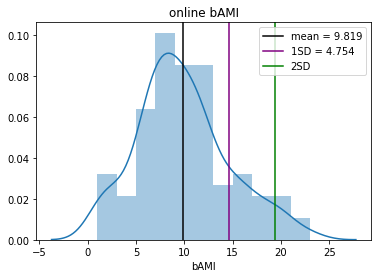

In [227]:
sns.distplot(AMI_prunned['bAMI']*6)
plt.title('online bAMI')
plt.axvline(x = 9.819, color = 'black', label = 'mean = 9.819')
plt.axvline(x = 14.573, color = 'purple', label = '1SD = 4.754')
plt.axvline(x = 19.327, color = 'green', label = '2SD')
plt.legend(loc = 1)
plt.savefig('online_bAMI.png', dpi = 300)

In [231]:
AMI_final.to_csv('AMI_100.csv', sep = ',', encoding='utf-8')

## HAD

### add 668245 to the dataset as nan

In [232]:
# import HAD
HAD = pd.read_csv('data_exp_6138-v39_task-w8es.csv', sep = ",")
HAD.drop(HAD.tail(1).index,inplace=True)
HAD = HAD[HAD['Participant Private ID'] != 668245] # twice

In [233]:
HAD_group = HAD.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(HAD_group['choice made'])
HAD_group = HAD_group.loc[HAD_group.index.repeat(15)]


In [234]:
len(HAD_group["Participant Private ID"].unique())

99

In [235]:
HAD_group['choice'] = choice
HAD_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*99

In [236]:
# question 12 is the trick question
HAD_group['scale'] = [{"Most of the time" : 3, "A lot of the time": 2, "From time to time, occasionally" : 1, "Not at all":0},
                      {"Nearly all the time": 3, "Very often": 2, "Sometimes": 1, "Not at all":0},
                      {"Definitely as much":0, "Not quite so much":1, "Only a little":2, "Hardly at all":3},
                      {"Not at all":0, "Occasionally":1, "Quite Often":2, "Very Often":3},
                      {"Very definitely and quite badly":3, "Yes, but not too badly":2, "A little, but it doesn't worry me":1, "Not at all":0},
                      {"Definitely":3, "I don't take as much care as I should":2,"I may not take quite as much care":1, "I take just as much care as ever":0},
                      {"As much as I always could":0, "Not quite so much now":1, "Definitely not so much now":2, "Not at all":3},
                      {"Very much indeed":3, "Quite a lot":2,"Not very much":1, "Not at all":0},
                      {"A great deal of the time":3, "A lot of the time":2, "From time to time, but not too often":1,"Only occasionally":0},
                      {"As much as I ever did":0, "Rather less than I used to":1, "Definitely less than I used to":2, "Hardly at all":3},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Very often indeed":3, "Quite often":2,"Not very often":1, "Not at all":0},
                      {"Definitely":0, "Usually":1, "Not Often":2,"Not at all":3},
                      {"Often":0, "Sometimes":1,"Not often":2, "Very seldom":3}]*99

In [237]:
# 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,    13, 14, 15
# A, D, D, A, A, D, D, A, A, D,   D,  trick, A,  A, D

# anxiety =  [1, 4, 5, 8, 9, 13, 14]
# depression = [2, 3, 6, 7, 10, 11, 15]

value = []
for index, row in HAD_group.iterrows():
    d = row["scale"]
    k = row['choice']
    value.append(d[k])
HAD_group['value'] = value

depression = HAD_group[(HAD_group.question_number == 2)|(HAD_group.question_number == 3)|(HAD_group.question_number == 6)|(HAD_group.question_number == 7)|(HAD_group.question_number == 10)|(HAD_group.question_number == 11)|(HAD_group.question_number == 15)]
anxiety = HAD_group[(HAD_group.question_number == 1)|(HAD_group.question_number == 4)|(HAD_group.question_number == 5)|(HAD_group.question_number == 8)|(HAD_group.question_number == 9)|(HAD_group.question_number == 13)|(HAD_group.question_number == 14)]
trick = HAD_group[(HAD_group.question_number == 12)]

In [238]:
depression = depression.groupby(['Participant Private ID'])['value'].sum().reset_index()
depression.columns = ['id', 'depression']
anxiety = anxiety.groupby(['Participant Private ID'])['value'].sum().reset_index()
anxiety.columns = ['id', 'anxiety']
#HAD_group.head(5)

In [239]:
HAD_final = {'id': anxiety['id'], 'anxiety': anxiety['anxiety'], 'depression': depression['depression']}
HAD_final = pd.DataFrame(data=HAD_final)
HAD_final['tHAD'] = anxiety['anxiety'] + depression['depression']
HAD_final.loc[-1] = [668245, np.nan, np.nan,  np.nan]

HAD_final.to_csv('HAD_100.csv', sep = ',', encoding='utf-8')

In [240]:
HAD_prunned = HAD_final[HAD_final['id'] != 668262.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 675528.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 675577.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 680119.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 672593.0] #missing high fix
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 683242.0] # only tapped 7 times 
                                                                           # in the low value env 
                                                                           # -> massive outlier in the data

## Baratt

In [241]:
# import Baratt
barrat = pd.read_csv('data_exp_6138-v39_task-df75.csv', sep = ",")
barrat.drop(barrat.tail(1).index,inplace=True)

In [242]:
barrat_group = barrat.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(barrat_group['choice made'])
barrat_group = barrat_group.loc[barrat_group.index.repeat(31)]

In [243]:
barrat_group['choice'] = choice
barrat_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22, 23, 24, 25, 26, 27, 28, 29, 30, 31]*100

In [244]:
reverse_barrat = barrat_group[barrat_group['question_number'].isin([9, 21,31, 1, 7, 8, 13, 14, 10, 16, 30])]
reverse_barrat.choice[reverse_barrat.choice == "Rarely/Never"] = 4
reverse_barrat.choice[reverse_barrat.choice == "Occasionally"] = 3
reverse_barrat.choice[reverse_barrat.choice == "Often"] = 2
reverse_barrat.choice[reverse_barrat.choice == "Almost always/Always"] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [245]:
# trick question
trick_barrat = barrat_group[barrat_group['question_number']==12]

In [246]:
barrat_group = barrat_group[barrat_group['question_number'].isin([5,11,29, 6, 25, 27, 2, 3, 4, 18, 20, 23, 26, 17, 22, 24,15, 19, 29])]
barrat_group.choice[barrat_group.choice == "Rarely/Never"] = 1
barrat_group.choice[barrat_group.choice == "Occasionally"] = 2
barrat_group.choice[barrat_group.choice == "Often"] = 3
barrat_group.choice[barrat_group.choice == "Almost always/Always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

### Calculate impulsivity score

In [247]:
barrat_group = pd.concat([barrat_group,reverse_barrat,trick_barrat])

In [248]:
# trick 12

# attentional =  [5, 9*, 11, 21*, 29, 6, 25, 27]
# attention = [5, 9*, 11, 21*, 29]
# Cognitive Instability = [6, 25, 27]
# motor = [2, 3, 4, 18, 20, 23, 26, 17, 22, 24, 31*]
# Motor = [2, 3, 4, 18, 20, 23, 26]
# Perseverance = [17, 22, 24, 31*]
# Nonplanning = [1*, 7*, 8*, 13*, 14*, 15, 10*, 16*, 19, 29, 30*]
# Self-Control = [1*, 7*, 8*, 13*, 14*, 15]
# Cognitive Complexity = [10*, 16*, 19, 28, 30*]
attention = barrat_group[(barrat_group.question_number == 5)|(barrat_group.question_number == 9)|(barrat_group.question_number == 11)|(barrat_group.question_number == 21)|(barrat_group.question_number == 29)]
cognitive_instable = barrat_group[(barrat_group.question_number == 6)|(barrat_group.question_number == 25)|(barrat_group.question_number == 27)]
motor = barrat_group[(barrat_group.question_number == 2)|(barrat_group.question_number == 3)|(barrat_group.question_number == 4)|(barrat_group.question_number == 18)|
                     (barrat_group.question_number == 20)|(barrat_group.question_number == 23)|(barrat_group.question_number == 26)]
perseverance = barrat_group[(barrat_group.question_number == 17)|(barrat_group .question_number == 22)|(barrat_group.question_number == 24)|(barrat_group.question_number == 31)]
self_control = barrat_group[(barrat_group.question_number == 1)|(barrat_group.question_number == 7)|(barrat_group.question_number == 8)|(barrat_group.question_number == 13)|(barrat_group.question_number == 14)|(barrat_group.question_number == 15)]
cognitive_complexity = barrat_group[(barrat_group.question_number == 10)|(barrat_group.question_number == 16)|(barrat_group.question_number == 19)|(barrat_group.question_number == 28)|(barrat_group.question_number == 30)]
trick = barrat_group[barrat_group.question_number == 12]



In [249]:
#trick
#668249, 672614, 675732, 672593

In [250]:
attention = attention.groupby(['Participant Private ID'])['choice'].sum().reset_index()
attention.columns = ['id', 'attention']
cognitive_instable = cognitive_instable.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_instable.columns = ['id', 'cognitive_instable']
motor = motor.groupby(['Participant Private ID'])['choice'].sum().reset_index()
motor.columns = ['id', 'motor']
perseverance = perseverance.groupby(['Participant Private ID'])['choice'].sum().reset_index()
perseverance.columns = ['id', 'perseverance']
self_control = self_control.groupby(['Participant Private ID'])['choice'].sum().reset_index()
self_control.columns = ['id', 'self_control']
cognitive_complexity = cognitive_complexity.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_complexity.columns = ['id', 'cognitive_complexity']

In [251]:
barrat_final = {'id': attention['id'], 'attention': attention['attention'], 
                'cognitive_instable': cognitive_instable['cognitive_instable'],
               'motor': motor['motor'],
               'perseverance': perseverance['perseverance'],
               'self_control': self_control['self_control'],
               'cognitive_complexity': cognitive_complexity['cognitive_complexity']}
barrat_final = pd.DataFrame(data=barrat_final)
barrat_final['attentional'] = attention['attention'] + cognitive_instable['cognitive_instable']
barrat_final['motor_0'] = motor['motor'] + perseverance['perseverance']
barrat_final['nonplanning'] = self_control['self_control'] + cognitive_complexity['cognitive_complexity']
barrat_final['total'] = barrat_final['attentional'] + barrat_final['motor_0'] + barrat_final['nonplanning']


In [252]:
barrat_final.to_csv('barrat_100.csv', sep = ',', encoding='utf-8')

## Pleasure

In [253]:
# import pleasure
pleasure = pd.read_csv('data_exp_6138-v39_task-uvof.csv', sep = ",")
pleasure.drop(pleasure.tail(1).index,inplace=True)

In [254]:
pleasure_group = pleasure.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(pleasure_group['choice made'])
pleasure_group = pleasure_group.loc[pleasure_group.index.repeat(15)]

In [255]:
pleasure_group['choice'] = choice
pleasure_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*100

In [256]:
# Definitely Agree (= 1)
# Agree (= 2)
# Disagree (= 3)
# Definitely Disagree (= 4)
pleasure_group.choice[pleasure_group.choice == "Strongly agree"] = 1
pleasure_group.choice[pleasure_group.choice == "Agree"] = 2
pleasure_group.choice[pleasure_group.choice == "Disagree"] = 3
pleasure_group.choice[pleasure_group.choice == "Strongly disagree"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.

In [257]:
trick = pleasure_group[pleasure_group.question_number == 8]
#trick.head(100)

In [258]:
pleasure_final = {'id': pleasure_group['Participant Private ID']}
pleasure_final = pd.DataFrame(data=pleasure_final)
p = pleasure_group.groupby('Participant Private ID')['choice'].sum().reset_index(name = 'total')
pleasure_final['total'] = p['total']
pleasure_final=pleasure_final.drop_duplicates()
len(pleasure_final)

100

In [259]:
pleasure_final.to_csv('pleasure_100.csv', sep = ',', encoding='utf-8')

## Fatigue

In [260]:
# import fatigue
fatigue = pd.read_csv('data_exp_6138-v39_task-j95b.csv', sep = ",")
fatigue.drop(fatigue.tail(1).index,inplace=True)

In [261]:
fatigue_group = fatigue.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice_fatigue= extract_choice(fatigue_group['choice made'])
fatigue_group = fatigue_group.loc[fatigue_group.index.repeat(22)]

In [262]:
fatigue_group['choice'] = choice_fatigue
fatigue_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22]*100

In [263]:
# 'Never', 'Rarely', 'Sometimes', 'Often', 'Almost always'
#   0         1          2            3           4
fatigue_group.choice[fatigue_group.choice == "Never"] = 0
fatigue_group.choice[fatigue_group.choice == "Rarely"] = 1
fatigue_group.choice[fatigue_group.choice == "Sometimes"] = 2
fatigue_group.choice[fatigue_group.choice == "Often"] = 3
fatigue_group.choice[fatigue_group.choice == "Almost always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [264]:
# trick question 5
# Physical 4, 7, 8, 11, 14, 15, 18, 21, 22
# Cognitive 1, 2, 3, 6, 12, 13, 16, 17, 19, 20
# Psychosocial 9, 10

fatigue_physical = fatigue_group[fatigue_group['question_number'].isin([4, 7, 8, 11, 14, 15, 18, 21, 22])]
fatigue_cognitive = fatigue_group[fatigue_group['question_number'].isin([1, 2, 3, 6, 12, 13, 16, 17, 19, 20])]
fatigue_psychological = fatigue_group[fatigue_group['question_number'].isin([9, 10])]
fatigue_trick = fatigue_group[fatigue_group['question_number'].isin([5])]

In [265]:
physical = fatigue_physical.groupby(['Participant Private ID'])['choice'].sum().reset_index()
physical.columns = ['id', 'physical']
cognitive = fatigue_cognitive.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive.columns = ['id', 'cognitive']
psychological = fatigue_psychological.groupby(['Participant Private ID'])['choice'].sum().reset_index()
psychological.columns = ['id', 'psychological']

In [266]:
fatigue_final = {'id': physical['id'], 'physical': physical['physical'], 
                'cognitive': cognitive['cognitive'],
               'psychological': psychological['psychological']}
fatigue_final = pd.DataFrame(data=fatigue_final)
fatigue_final['total'] = fatigue_final['physical'] + fatigue_final['cognitive'] + fatigue_final['psychological']

fatigue_final.to_csv('fatigue_100.csv', sep = ',', encoding='utf-8')